In [11]:
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import glob
import cv2
from YOLOv8FeatureExtractor import YOLOv8FeatureExtractor
import matplotlib.pyplot as plt
from MultiLoaderData import OTBMultiSequenceDataset

In [8]:
#from rolo_model import ROLO_LSTM
#from yolo_feature_extractor import YOLOv8FeatureExtractor
#from rolo_dataset import RoloSequenceDataset

model = YOLO('yolov8s.pt')

In [3]:
class YOLOv8FeatureExtractor:
    def __init__(self, model_path='yolov8s.pt', device=None, feature_layer=-2):
        """
        model_path: Ruta al modelo YOLOv8 (p.ej. 'yolov8s.pt')
        device: 'cuda' o 'cpu'
        feature_layer: Índice de la capa desde donde extraer características
        """
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = YOLO(model_path).to(self.device)
        self.model.eval()
        self.feature_layer = feature_layer

    def extract(self, image):
        """
        Procesa una imagen y devuelve bbox y feature vector.
        image: numpy array (HxWx3) en formato RGB
        returns: bbox (x, y, w, h) normalizado y feature vector
        """
        # Paso 1: Run YOLOv8 forward
        result = self.model.predict(image, verbose=False)[0]

        # Paso 2: Obtener detecciones
        detections = result.boxes
        if detections is None or len(detections.conf) == 0:
            return None, None  # No detección

        # Tomar la detección más confiable (sin filtrar por clase)
        scores = detections.conf
        boxes = detections.xywhn  # Normalizado (x_center, y_center, width, height)
        best_idx = scores.argmax()
        bbox = boxes[best_idx].cpu().numpy()

        # Paso 3: Extraer características desde la capa deseada
        with torch.no_grad():
            input_tensor = self.model.transforms(image, self.device)[0]
            feature_maps = self.model.model[:self.feature_layer + 1](input_tensor)

            if isinstance(feature_maps, (list, tuple)):
                feat = feature_maps[-1]
            else:
                feat = feature_maps

            # Pooling para vector fijo
            feature_vector = torch.nn.functional.adaptive_avg_pool2d(feat, 1).squeeze().flatten()
            feature_vector = feature_vector.cpu().numpy()

        return bbox, feature_vector

In [ ]:
class ROLO_LSTM(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128, num_layers=1):
        """
        feature_dim: dimensión del vector de características (D)
        hidden_dim: dimensión del estado oculto de la LSTM
        num_layers: número de capas LSTM
        """
        super(ROLO_LSTM, self).__init__()

        self.input_dim = feature_dim + 4  # [features + bbox]
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(self.hidden_dim, 4)  # predice bbox: (x, y, w, h)

    def forward(self, x, hidden=None):
        """
        x: Tensor de entrada (batch_size, seq_len, input_dim)
        hidden: estado inicial de la LSTM (opcional)
        returns: predicciones (batch_size, seq_len, 4)
        """
        lstm_out, hidden = self.lstm(x, hidden)
        output = self.fc(lstm_out)
        return output, hidden

In [5]:
print(model.model)  # Muestra toda la arquitectura

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    


0: 384x640 5 birds, 29.8ms
Speed: 2.0ms preprocess, 29.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Clase: 14, Confianza: 0.62
Caja: x1=363.7, y1=153.3, x2=405.5, y2=179.1
Parando en bloque 11: Concat
Features shape: torch.Size([1, 512, 40, 40])
Vector final: torch.Size([512])
Bounding Box: [    0.53416     0.41547    0.057992    0.064653]
Feature Vector: (512,)
Clase: 14


(-0.5, 719.5, 399.5, -0.5)

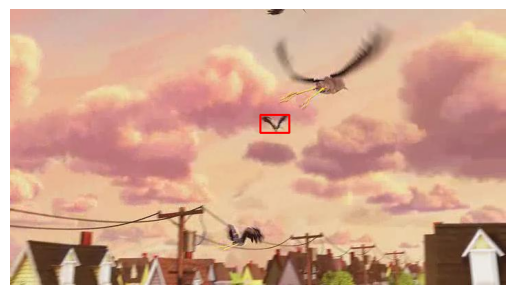

In [10]:
image_path = 'OTB100/Bird1/img/0001.jpg'  # Cambia esto a tu imagen
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

extractor = YOLOv8FeatureExtractor(model_path='yolov8s.pt', feature_layer=8)
bbox, feature_vector, clase = extractor.extract(image)
if bbox is not None and feature_vector is not None:
    print("Bounding Box:", bbox)
    print("Feature Vector:", feature_vector.shape)
    print("Clase:", clase)

# Visualizar la imagen con la bounding box
x,y,w,h = bbox
x1, y1 = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
x2, y2 = int((x + w / 2) * image.shape[1]), int((y + h / 2) * image.shape[0])

image_draw = image.copy()
cv2.rectangle(image_draw, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(image_draw)
plt.axis('off')

In [12]:
# Inicializar extractor
extractor = YOLOv8FeatureExtractor(model_path='yolov8s.pt', device='cuda')

# Inicializar dataset
dataset = OTBMultiSequenceDataset(root_dir='OTB100', extractor=extractor, seq_len=5)

# Usar DataLoader si quieres probar batching
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Obtener un batch
for i, (inputs, target_box) in enumerate(loader):
    print(f"Secuencia {i}")
    print(f"Inputs shape: {inputs.shape}")        # [batch, seq_len, feature_dim]
    print(f"Target bbox: {target_box.shape}")     # [batch, 4]
    print(f"First input (feature+box): {inputs[0,0,:10]}")
    break  # solo 1 muestra


0: 640x640 4 airplanes, 5 birds, 4.2ms
Speed: 1.9ms preprocess, 4.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Clase: 14, Confianza: 0.77
Caja: x1=191.5, y1=140.7, x2=239.8, y2=174.6
Parando en bloque 11: Concat
Features shape: torch.Size([1, 512, 40, 40])
Vector final: torch.Size([512])

0: 640x640 2 airplanes, 5 birds, 1 kite, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Clase: 14, Confianza: 0.74
Caja: x1=508.2, y1=157.6, x2=567.2, y2=202.0
Parando en bloque 11: Concat
Features shape: torch.Size([1, 512, 40, 40])
Vector final: torch.Size([512])

0: 640x640 5 airplanes, 3 birds, 1 snowboard, 4.0ms
Speed: 1.6ms preprocess, 4.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Clase: 4, Confianza: 0.63
Caja: x1=214.6, y1=66.7, x2=266.8, y2=88.5
Parando en bloque 11: Concat
Features shape: torch.Size([1, 512, 40, 40])
Vector final: torch.Size([512])

0: 640x640 1 airplane, 3 birds, 3.9ms